# 22. K-Means Clustering

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/22.K-MEANS-Clustering.ipynb)

(Based on https://medium.com/@arifromadhan19/step-by-step-to-understanding-k-means-clustering-and-implementation-with-sklearn-b55803f519d6)

In this notebook, we will apply an unsupervised machine learning method for clustering, called K-Means Clustering.

### Eight Steps of K-Means Clustering

<img src="https://github.com/rhennig/EMA6938/blob/main/Notebooks/Figures/K-MeansClustering.png?raw=1" alt="K-Means Clustering Algorithm" align="center" style="width:500px; float:center"/>

### Create a Dataset

Before we apply the clustering technique, we create a dataset of materials with experimental bandgaps.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn import decomposition

from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

data = load_dataset("expt_gap")
data.describe()

,gap expt
count,6354.000000
mean,1.252225
std,1.539961
min,0.000000
25%,0.000000
50%,0.710000
75%,2.130000
max,11.700000


In [2]:
data.head()

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


In [3]:
# How many unique compositions do we have?
data["formula"].unique().shape[0]

4934

In [4]:
# Sort by size of badgap
data = data.sort_values('gap expt')

# Remove duplicate compositions
data = data.drop_duplicates('formula')

data.describe()

,gap expt
count,4934.000000
mean,1.042454
std,1.481024
min,0.000000
25%,0.000000
50%,0.070000
75%,1.900000
max,11.700000


### Obtain a Feature Vector for Each Material

The first step in building a machine learning model is to convert the raw materials data, here the composition, into the required input for an ML model: a finite list of quantitative attributes. Here we use the Magpie descriptors from Ward et al.

In [5]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

# Get the feature names
feature_labels = feature_calculators.feature_labels()

# Compute the features for all materials entries
data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, 'formula')
data = feature_calculators.featurize_dataframe(data, col_id='composition_obj', ignore_errors=True);

StrToComposition:   0%|          | 0/4934 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/4934 [00:00<?, ?it/s]

/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/rhennig/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: T

In [6]:
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))
print('Feature labels', feature_labels)

Generated 145 features
Training set size: 4934x145
Feature labels ['0-norm', '2-norm', '3-norm', '5-norm', '7-norm', '10-norm', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData minimum Column', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData mean Colu

In [7]:
# Retain only numerical values
data_num = data.select_dtypes([np.number])
data_num.head(10)
data_num.describe()

,gap expt,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,...,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,max ionic char,avg ionic char
count,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4934.000000,4933.000000,4933.000000,4933.000000,...,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000
mean,1.042454,3.021281,0.663279,0.602817,0.573417,0.565681,0.561354,19.426718,57.569633,38.142915,...,131.720860,138.140163,52.257520,101.629840,1.845001,1.888540,4.513762,1.819700,0.345914,0.063426
std,1.481024,0.713992,0.072369,0.088178,0.100393,0.105375,0.108943,14.675379,18.989044,20.044184,...,79.048725,55.122686,34.088376,85.679466,0.235426,1.085544,3.213897,2.814162,0.264493,0.052034
min,0.000000,2.000000,0.500000,0.396850,0.329877,0.304753,0.287175,1.000000,5.000000,1.000000,...,0.000000,8.000000,0.000000,2.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.612372,0.538609,0.506099,0.501109,0.500098,8.000000,46.000000,22.000000,...,52.000000,93.350000,16.932099,14.000000,1.750000,0.857143,1.666667,0.000000,0.109169,0.019482
50%,0.070000,3.000000,0.654654,0.598828,0.574349,0.552045,0.546393,15.000000,57.000000,37.000000,...,159.000000,127.928571,55.111111,70.000000,2.000000,2.153846,4.000000,0.000000,0.285663,0.049707
75%,1.900000,4.000000,0.707107,0.652985,0.626314,0.625147,0.625007,30.000000,75.000000,52.000000,...,213.000000,194.000000,83.657764,194.000000,2.000000,2.666667,7.142857,3.000000,0.539020,0.097843
max,11.700000,4.000000,0.999001,0.999000,0.999000,0.999000,0.999000,83.000000,92.000000,91.000000,...,227.000000,229.000000,113.500000,229.000000,2.000000,5.000000,10.000000,14.000000,0.921450,0.230363


In [8]:
# Drop the columns that include incomplete data
data_num = data_num.dropna(axis=0)

data_num.describe()

,gap expt,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,...,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,max ionic char,avg ionic char
count,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,...,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000
mean,1.042418,3.021083,0.663211,0.602737,0.573331,0.565594,0.561266,19.426718,57.569633,38.142915,...,131.720860,138.140163,52.257520,101.629840,1.845001,1.888540,4.513762,1.819700,0.345914,0.063426
std,1.481172,0.713928,0.072219,0.088007,0.100220,0.105205,0.108777,14.675379,18.989044,20.044184,...,79.048725,55.122686,34.088376,85.679466,0.235426,1.085544,3.213897,2.814162,0.264493,0.052034
min,0.000000,2.000000,0.500000,0.396850,0.329877,0.304753,0.287175,1.000000,5.000000,1.000000,...,0.000000,8.000000,0.000000,2.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.612372,0.538609,0.506099,0.501109,0.500098,8.000000,46.000000,22.000000,...,52.000000,93.350000,16.932099,14.000000,1.750000,0.857143,1.666667,0.000000,0.109169,0.019482
50%,0.070000,3.000000,0.654654,0.598828,0.574349,0.552045,0.546393,15.000000,57.000000,37.000000,...,159.000000,127.928571,55.111111,70.000000,2.000000,2.153846,4.000000,0.000000,0.285663,0.049707
75%,1.900000,4.000000,0.707107,0.652985,0.626314,0.625147,0.625007,30.000000,75.000000,52.000000,...,213.000000,194.000000,83.657764,194.000000,2.000000,2.666667,7.142857,3.000000,0.539020,0.097843
max,11.700000,4.000000,0.999001,0.999000,0.999000,0.999000,0.999000,83.000000,92.000000,91.000000,...,227.000000,229.000000,113.500000,229.000000,2.000000,5.000000,10.000000,14.000000,0.921450,0.230363


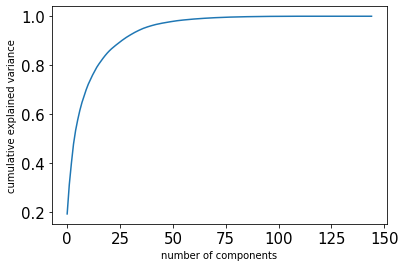

In [9]:
# Standardizing the features
from sklearn.preprocessing import StandardScaler
data_std = StandardScaler().fit_transform(data_num)

# Principal component analysis to project onto first two principal components
from sklearn.decomposition import PCA

# Plot explained variance
pca = PCA()
pca.fit(data_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [10]:

# Project onto two principal components
pca = PCA(n_components=2)
pca.fit(data_std)
principalComponents = pca.fit_transform(data_std)
data_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

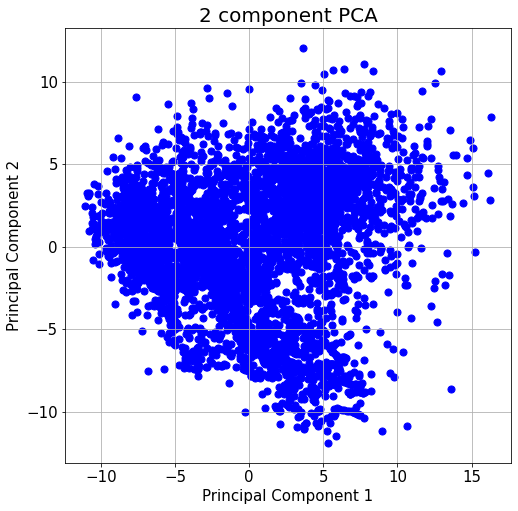

In [11]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(data_pca['principal component 1'], data_pca['principal component 2']
               , c = 'blue'
               , s = 50)
ax.grid()

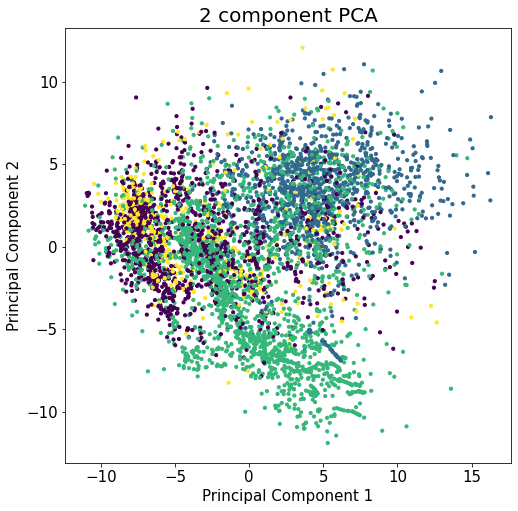

In [12]:
# implementing k-means clustering
from sklearn import cluster
kmeans_data = cluster.KMeans(n_clusters=4, max_iter=300, 
                                 init='k-means++',n_init=10).fit_predict(data_num)

# Plot clusters
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(data_pca['principal component 1'], data_pca['principal component 2'],
           c = kmeans_data, s = 10)
plt.show()